In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgi

In [4]:
dataset_name = "coauth-dblp"

with open("index.json") as file:
    data = json.load(file)
url = data[dataset_name]["url"]

H = xgi.from_hypergraph_dict(xgi.request_json_from_url(url))

In [5]:
print(H)
num_nodes = H.num_nodes
num_edges = H.num_edges

Hypergraph named coauth-DBLP with 1930378 nodes and 3700681 hyperedges


In [6]:
simpleH = H.copy()
simpleH.merge_duplicate_edges()
print(simpleH)
num_unique_edges = simpleH.num_edges

Hypergraph named coauth-DBLP with 1930378 nodes and 2467389 hyperedges


In [7]:
s = H.edges.size
smin = s.min()
smax = s.max()
smean = s.mean()
print(f"The min edge size is {smin}")
print(f"The max edge size is {smax}")
print(f"The mean edge size is {smean}")

The min edge size is 1
The max edge size is 280
The mean edge size is 2.79050612576442


In [8]:
d = H.nodes.degree
dmin = d.min()
dmax = d.max()
dmean = d.mean()
print(f"The min degree is {dmin}")
print(f"The max degree is {dmax}")
print(f"The mean degree is {dmean}")

The min degree is 1
The max degree is 1425
The mean degree is 5.349611837681532


In [9]:
cc = [len(c) for c in xgi.connected_components(H)]
vals, counts = np.unique(cc, return_counts=True)

size_gc = max(vals)
num_components = len(vals)

pd.DataFrame({"Component Size": vals, "Number": counts})

,Component Size,Number
0,1,93782
1,2,33625
2,3,14373
3,4,6092
4,5,2925
5,6,1444
6,7,750
7,8,457
8,9,272
9,10,182


In [10]:
with open("index.json") as file:
    data = json.load(file)

props = {
    "num-nodes": int(num_nodes),
    "num-edges": int(num_edges),
    "num-unique-edges": int(num_unique_edges),
    "min-edge-size": int(smin),
    "max-edge-size": int(smax),
    "mean-edge-size": round(smean, 2),
    "min-degree": int(dmin),
    "max-degree": int(dmax),
    "mean-degree": round(dmean, 2),
    "num-components": int(num_components),
    "gc-size": int(size_gc),
}
data[dataset_name].update(props)

datastring = json.dumps(data, indent=2)

with open("index.json", "w") as output_file:
    output_file.write(datastring)

In [11]:
def plot_distributions(
    H,
    node_bins=None,
    edge_bins=None,
    log_x1=True,
    log_y1=True,
    log_x2=True,
    log_y2=True,
):

    if node_bins is None:
        node_bins = int(H.num_nodes / 20)
        node_bins = min(node_bins, 100)

    if edge_bins is None:
        s = H.edges.size
        edge_bins = int(s.max() - s.min() + 1)
        edge_bins = min(edge_bins, 100)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)

    h1 = H.nodes.degree.ashist(bins=node_bins, density=True, log_binning=log_x1)
    h2 = H.edges.size.ashist(bins=edge_bins, density=True, log_binning=log_x2)
    y1 = h1[h1.value > 0].value
    y2 = h2[h2.value > 0].value
    ymin = 0.95 * min(y1.min(), y2.min())
    ymax = 1.1 * max(y1.max(), y2.max())

    if log_x1 and log_y1:
        plt.loglog(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif log_x1 and not log_y1:
        plt.semilogx(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and log_y1:
        plt.semilogy(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and not log_y1:
        plt.plot(h1["bin_center"], h1["value"], "ko", markersize=2)

    plt.title("Degree distribution")
    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()

    plt.subplot(122)

    if log_x2 and log_y2:
        plt.loglog(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif log_x2 and not log_y2:
        plt.semilogx(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and log_y2:
        plt.semilogy(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and not log_y2:
        plt.plot(h2["bin_center"], h2["value"], "ko", markersize=2)

    plt.title("Edge size distribution")
    plt.xlabel(r"$s$", fontsize=16)
    plt.ylabel(r"$P(s)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()
    plt.tight_layout()
    Path(f"datasheets/{dataset_name}").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"datasheets/{dataset_name}/stats.png", dpi=300)
    plt.show()

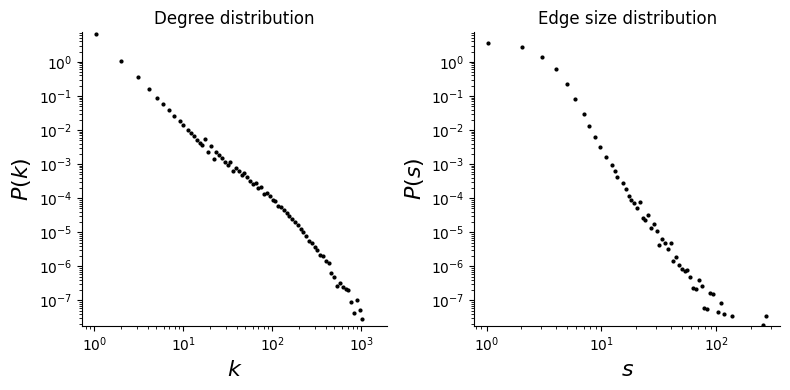

In [12]:
plot_distributions(H, log_x1=True, log_y1=True, log_x2=True, log_y2=True)